In [1]:
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

/home/darek/mambaforge/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('../input/feedback-effective-folds/train_folds.csv')
train.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,score,fold
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1,0
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,1,0
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,1,0
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,1,0
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,1,0


In [3]:
essays = pd.read_csv('../input/feedback-effective-folds/essay_scores.csv')
essays.head()

,essay_id,score,group,fold
0,F98E8D4EA700,0.777778,2,0
1,66BB82BD76B2,0.875000,2,0
2,85F4C57672EA,0.923077,2,0
3,06936C8AA35D,1.666667,3,0
4,61C3ADEA1DD5,0.666667,2,0


In [4]:
texts = {x: "" for x in train.essay_id.unique().tolist()}
for f in os.listdir('../input/feedback-prize-effectiveness/train'):
    with open(f'../input/feedback-prize-effectiveness/train/{f}') as file:
        text = file.read()
        text = text.replace('\n', '|')
        essay_id = f.split('.')[0]
        texts[essay_id] = text

In [5]:
train.groupby('essay_id')['discourse_id'].count().min(), train.groupby('essay_id')['discourse_id'].count().max()

(1, 23)

In [6]:
checkpoint = 'microsoft/deberta-v3-large'
# checkpoint = 'microsoft/deberta-v3-small'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/darek/mambaforge/envs/ml/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def get_start_and_end(essay_id):
    discourse_id_2_startend = []
    all_discourses = train[train.essay_id == essay_id]['discourse_text'].values.tolist()
    all_ids = train[train.essay_id == essay_id]['discourse_id'].values.tolist()
    text = texts[essay_id]
    start = 0
    end = 0
    for i in range(len(all_discourses)):
        discourse = all_discourses[i]
        disc_id = all_ids[i]
        start = end + text[end:].find(discourse)
        # special case if we can't find exact match
        j = -1
        while start - end == -1:
            start = end + text[end:].find(discourse[:j])
            j -= 1
        # end of special case
        end = start + len(discourse)
        discourse_id_2_startend.append((disc_id, start, end))
    return discourse_id_2_startend

In [8]:
from tqdm.auto import tqdm 

mappings = []
for esid in tqdm(essays.essay_id.unique().tolist()):
    mappings.extend(get_start_and_end(esid))

100%|███████████████████████████████████████████████████████████| 4191/4191 [00:23<00:00, 181.61it/s]


In [9]:
mappings[0], len(mappings)

(('3abf8b923b81', 0, 40), 36765)

In [10]:
len(train)

36765

In [11]:
map_dict = {m[0]: (m[1],m[2]) for m in mappings}

In [12]:
train['start_end'] = train['discourse_id'].apply(lambda x: map_dict[x])

In [ ]:
type2id = {x: i for i,x in enumerate(train.discourse_type.unique().tolist())}
type2id['Other'] = 7
type2id

{'Lead': 0,
 'Position': 1,
 'Claim': 2,
 'Evidence': 3,
 'Counterclaim': 4,
 'Rebuttal': 5,
 'Concluding Statement': 6,
 'Other': 7}

In [ ]:
id2type = {i:x for x,i in type2id.items()}
id2type[-100] = 'Mask'
id2type

{0: 'Lead',
 1: 'Position',
 2: 'Claim',
 3: 'Evidence',
 4: 'Counterclaim',
 5: 'Rebuttal',
 6: 'Concluding Statement',
 7: 'Other',
 -100: 'Mask'}

In [ ]:
def chck(a):
    mx = max(a)
    try:
        for i in range(mx+1):
            assert(i in a)
        return True
    except:
        return False

In [33]:
def process_essay(esid, max_length=None):

    token_class_labels = []
    token_scores_labels = []
    token_examples_mapping = []
    examples_scores = []
    examples_classes = []

    text = texts[esid]
    essay_score = essays[essays.essay_id == esid]['score'].values[0]
    tokens = tokenizer(text, return_offsets_mapping=True)
    
    start_ends = train[train.essay_id == esid]['start_end'].values.tolist()
    discourse_types = train[train.essay_id == esid]['discourse_type'].values.tolist()
    scores = train[train.essay_id == esid]['score'].values.tolist()

    for ts,te in tokens['offset_mapping']:
        match = False
        if ts == te: 
            token_class_labels.append(-100)
            token_scores_labels.append(-100)
            token_examples_mapping.append(-100)
            match = True
        else:
            for i, ((ds,de), discourse_type, discourse_score) in enumerate(list(zip(
                start_ends,
                discourse_types,
                scores,
            ))):
                if ts >= ds-1 and te <= de and ts != te:
                    token_class_labels.append(type2id[discourse_type])
                    token_scores_labels.append(discourse_score)
                    token_examples_mapping.append(i)
                    match = True
                    break
        if match == False:
            token_class_labels.append(type2id['Other'])
            token_scores_labels.append(-100)
            token_examples_mapping.append(-100)
#         print(ts,te,match)

    for i, (discourse_type, discourse_score) in enumerate(list(zip(
        discourse_types,
        scores,
    ))):
        examples_scores.append(discourse_score)
        examples_classes.append(type2id[discourse_type])
        
    try: 
        assert len(token_class_labels) == len(tokens['input_ids'])
        assert len(token_scores_labels) == len(tokens['input_ids'])
        assert len(token_examples_mapping) == len(tokens['input_ids'])
        assert len(examples_scores) == len(examples_classes)
        # assert len(token_class_labels) == max_length
        assert chck(token_examples_mapping)
        assert len(discourse_types) == max(token_examples_mapping) + 1

    except: 
        print('Wrong!!', esid)
        
    return {
        'essay_id': esid,
        'fold': essays[essays.essay_id == esid].fold.values[0],
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask'],
        'offset_mapping': tokens['offset_mapping'],
        'token_class_labels': token_class_labels,
        'token_scores_labels': token_scores_labels,
        'token_examples_mapping': token_examples_mapping,
        'examples_scores': examples_scores,
        'examples_classes': examples_classes,
    }


In [34]:
train[train.essay_id == '0F2199921C33']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,score,fold,start_end
780,89554ddc22e1,0F2199921C33,Do you remember the summer projects that you h...,Lead,Adequate,1,0,"(0, 302)"
781,cec88a31dcf3,0F2199921C33,The summer projects should be teacher designed,Position,Adequate,1,0,"(302, 349)"
782,c81b32b22872,0F2199921C33,it gives the teacher a chance to gauge the stu...,Claim,Effective,2,0,"(357, 424)"
783,27ca36a0bda2,0F2199921C33,base it on what they will be learning that year,Claim,Effective,2,0,"(424, 472)"
784,9a6b9a33d90a,0F2199921C33,and learn the learning style of students. \n,Claim,Effective,2,0,"(472, 515)"
785,614cd99fec55,0F2199921C33,Some say that student designed summer projects...,Counterclaim,Effective,2,0,"(515, 675)"
786,a2c4308dd1bf,0F2199921C33,And while it may be good that the student is i...,Rebuttal,Effective,2,0,"(675, 939)"
787,655dee8bcbf1,0F2199921C33,A student who is knowable able about history m...,Evidence,Effective,2,0,"(940, 1954)"
788,6c1d9b65465f,0F2199921C33,Teacher-designed summer projects allow teacher...,Claim,Effective,2,0,"(1955, 2055)"
789,a5d11fe804cd,0F2199921C33,The teacher can create different problems base...,Evidence,Effective,2,0,"(2055, 2801)"


In [35]:
len(train[train.essay_id == '0F2199921C33'])

15

In [36]:
ttt = process_essay('0F2199921C33')

In [37]:
ttt.keys()

dict_keys(['essay_id', 'fold', 'input_ids', 'attention_mask', 'offset_mapping', 'token_class_labels', 'token_scores_labels', 'token_examples_mapping', 'examples_scores', 'examples_classes'])

In [38]:
token_examples_mapping = ttt['token_examples_mapping']
examples_scores = ttt['examples_scores']
input_ids = ttt['input_ids']

num_ex = max(token_examples_mapping)

num_ex, len(examples_scores)

import torch
# for i in range(num_ex + 1):
#     indices = torch.tensor(token_examples_mapping) == i
#     tokens = torch.tensor(input_ids)[indices]
#     text = tokenizer.decode(tokens)
#     print(text)

for i, (_, row) in enumerate(train[train.essay_id == '0F2199921C33'].iterrows()):
    indices = torch.tensor(token_examples_mapping) == i
    tokens = torch.tensor(input_ids)[indices]
    text = tokenizer.decode(tokens)
    text2 = row['discourse_text']
    print(i, text==text2)
    print(text)
    print('*'*60)
    print(text2)
    print('*'*60)

    

0 False
Do you remember the summer projects that you had to do during summer break? Even now as fewer places require summer projects for all class,they are still an important thing for both students and teachers. They allow both so see how the other is either by teaching style or how they did on the content.
************************************************************
Do you remember the summer projects that you had to do during summer break? Even now as fewer places require summer projects for all class,they are still an important thing for both students and teachers. They allow both so see how the other is either by teaching style or how they did on the content. 
************************************************************
1 False
The summer projects should be teacher designed
************************************************************
The summer projects should be teacher designed 
************************************************************
2 False
it gives the teacher a chance to

In [39]:
from tqdm.auto import tqdm
processed_data = []
for esid in tqdm(train.essay_id.unique().tolist()):
    processed_data.append(process_essay(esid))

  1%|▊                                                             | 52/4191 [00:00<00:56, 73.68it/s]

Wrong!! 077A62D46D30
Wrong!! 086603D5B319


  2%|█▍                                                           | 100/4191 [00:01<00:46, 88.51it/s]

Wrong!! 0DDCAFAEA487
Wrong!! 0F23D0A1E0F0


  3%|█▉                                                           | 136/4191 [00:01<00:53, 75.90it/s]

Wrong!! 12C08C0F6EE1
Wrong!! 130F9B6DCCF9


  5%|███                                                          | 212/4191 [00:02<00:44, 89.48it/s]

Wrong!! 1D6188632F9B
Wrong!! 1E235AB03C8A


  5%|███▎                                                         | 230/4191 [00:02<00:45, 87.89it/s]

Wrong!! 20162733792B
Wrong!! 218490FD2E1B
Wrong!! 22049B234D6C
Wrong!! 22416450E0EF


  6%|███▋                                                         | 257/4191 [00:03<00:46, 85.18it/s]

Wrong!! 2321FAC1E823


  7%|████                                                         | 275/4191 [00:03<00:45, 85.15it/s]

Wrong!! 25C41D233D24


  8%|████▊                                                        | 331/4191 [00:04<00:43, 88.20it/s]

Wrong!! 2DA25C61D18D
Wrong!! 2DC33D804E4A
Wrong!! 2E67DBD40D46


  9%|█████▍                                                       | 376/4191 [00:04<00:45, 83.97it/s]

Wrong!! 34C979F3ABAA
Wrong!! 35C1EF0AD877


 10%|█████▊                                                       | 403/4191 [00:04<00:44, 85.62it/s]

Wrong!! 38F506B031E1


 10%|██████▎                                                      | 430/4191 [00:05<00:43, 86.27it/s]

Wrong!! 3BFD98581812


 11%|██████▌                                                      | 448/4191 [00:05<00:43, 86.37it/s]

Wrong!! 3EEDE8AD3CB3
Wrong!! 3F8C6F9EBDEB


 12%|███████▏                                                     | 493/4191 [00:05<00:42, 86.84it/s]

Wrong!! 43FDEB1E411C


 12%|███████▌                                                     | 521/4191 [00:06<00:41, 87.84it/s]

Wrong!! 47953D11C79C
Wrong!! 47CAD052900E


 14%|████████▎                                                    | 567/4191 [00:06<00:40, 88.42it/s]

Wrong!! 4FAC3B29417F


 14%|████████▊                                                    | 604/4191 [00:07<00:43, 83.04it/s]

Wrong!! 53E064890ABC
Wrong!! 54351180CD4F


 15%|█████████                                                    | 622/4191 [00:07<00:42, 84.03it/s]

Wrong!! 57596DF3AD20


 16%|█████████▊                                                   | 677/4191 [00:08<00:41, 85.55it/s]

Wrong!! 6198205BB70E
Wrong!! 62BC144D48C1


 17%|██████████▋                                                  | 731/4191 [00:08<00:41, 83.24it/s]

Wrong!! 69A1A0E6B176
Wrong!! 6A273D6F0816
Wrong!! 6C09B4AA6A77


 18%|███████████▏                                                 | 767/4191 [00:09<00:40, 83.95it/s]

Wrong!! 6FAA9368824D


 19%|███████████▋                                                 | 803/4191 [00:09<00:40, 83.36it/s]

Wrong!! 749A62B003A5


 20%|███████████▉                                                 | 821/4191 [00:09<00:39, 84.26it/s]

Wrong!! 761E554AE3D8
Wrong!! 7742D58270C9
Wrong!! 7794085FE26D


 20%|████████████▎                                                | 848/4191 [00:10<00:39, 84.17it/s]

Wrong!! 7A3E4D5F7F6D
Wrong!! 7BE3B580C5DB
Wrong!! 7D378AEFD0C3


 21%|████████████▌                                                | 866/4191 [00:10<00:40, 81.14it/s]

Wrong!! 7E2EF53A56BC
Wrong!! 7EC34F21069A


 21%|████████████▉                                                | 885/4191 [00:10<00:39, 83.97it/s]

Wrong!! 80FE1A70F85C
Wrong!! 811B878CE2C1


 22%|█████████████▎                                               | 912/4191 [00:10<00:38, 84.16it/s]

Wrong!! 84305C417C4B
Wrong!! 84DA3A4E84CC


 22%|█████████████▋                                               | 940/4191 [00:11<00:37, 85.77it/s]

Wrong!! 8836AD393A34
Wrong!! 8A658A988B96


 23%|██████████████                                               | 968/4191 [00:11<00:37, 86.34it/s]

Wrong!! 8BFA8777316F


 24%|██████████████▍                                              | 995/4191 [00:11<00:38, 83.96it/s]

Wrong!! 902A59ECB525
Wrong!! 90345B5B064D
Wrong!! 90BC4A0EDED0
Wrong!! 920DC8B0BC4E


 24%|██████████████▌                                             | 1014/4191 [00:12<00:36, 86.17it/s]

Wrong!! 939C163906D1


 25%|██████████████▊                                             | 1032/4191 [00:12<00:40, 77.36it/s]

Wrong!! 95DC8A3C2EFD
Wrong!! 9615F113FAA1


 25%|███████████████                                             | 1049/4191 [00:12<00:43, 72.13it/s]

Wrong!! 9865A4972C51
Wrong!! 98B33A9F1D9C


 26%|███████████████▍                                            | 1075/4191 [00:12<00:41, 74.20it/s]

Wrong!! 9AED08D70C4C


 27%|████████████████▏                                           | 1130/4191 [00:13<00:35, 85.12it/s]

Wrong!! A3041B0D7D5E
Wrong!! A4ADCC04C319


 28%|████████████████▊                                           | 1175/4191 [00:14<00:35, 84.55it/s]

Wrong!! A954E3B54194


 28%|█████████████████                                           | 1193/4191 [00:14<00:36, 83.10it/s]

Wrong!! AC5F232F9F99


 30%|██████████████████▏                                         | 1274/4191 [00:15<00:35, 81.43it/s]

Wrong!! B7E936A82959
Wrong!! B8B5B46DA523


 31%|██████████████████▋                                         | 1302/4191 [00:15<00:33, 85.78it/s]

Wrong!! BAC5264E2DCE


 31%|██████████████████▉                                         | 1320/4191 [00:15<00:33, 84.61it/s]

Wrong!! BDCD981437BB
Wrong!! BE1F20C5B099
Wrong!! BE243683124A


 33%|███████████████████▌                                        | 1366/4191 [00:16<00:33, 85.41it/s]

Wrong!! C5021AF61E5F
Wrong!! C51752A9035C
Wrong!! C5A3278EB458
Wrong!! C7373B980F7E
Wrong!! C7FA88E9DF3B


 34%|████████████████████▏                                       | 1411/4191 [00:16<00:33, 83.43it/s]

Wrong!! CBA185D3B277


 34%|████████████████████▌                                       | 1438/4191 [00:17<00:32, 84.80it/s]

Wrong!! CFAFADA9A2C3


 35%|████████████████████▊                                       | 1456/4191 [00:17<00:32, 83.73it/s]

Wrong!! D228AB564BF6


 36%|█████████████████████▍                                      | 1501/4191 [00:18<00:31, 84.18it/s]

Wrong!! D8FA1F4C6D5C
Wrong!! D99A8FDB17D8


 36%|█████████████████████▋                                      | 1519/4191 [00:18<00:31, 85.07it/s]

Wrong!! DBBF3EF47E93
Wrong!! DE01C3FDCA0A


 37%|██████████████████████▏                                     | 1547/4191 [00:18<00:30, 86.94it/s]

Wrong!! E04E83CEF5DA


 37%|██████████████████████▍                                     | 1565/4191 [00:18<00:30, 86.60it/s]

Wrong!! E34D011F7B98
Wrong!! E595E218D423


 38%|██████████████████████▉                                     | 1601/4191 [00:19<00:29, 87.47it/s]

Wrong!! E76B78A22B99
Wrong!! E8DD7458130E
Wrong!! E9E9AEC9100C


 39%|███████████████████████▎                                    | 1628/4191 [00:19<00:30, 84.52it/s]

Wrong!! EBD36D034DAC
Wrong!! EC7C81E59E9E
Wrong!! ED7F7B6E4C8E


 40%|████████████████████████                                    | 1682/4191 [00:20<00:30, 83.44it/s]

Wrong!! F2C57EEEF02C


 41%|████████████████████████▎                                   | 1700/4191 [00:20<00:29, 83.21it/s]

Wrong!! F50D3D001E67


 42%|█████████████████████████                                   | 1754/4191 [00:21<00:28, 85.44it/s]

Wrong!! FB6A513EBFC6


 43%|█████████████████████████▋                                  | 1792/4191 [00:21<00:27, 86.93it/s]

Wrong!! 0056F3D261D5


 43%|██████████████████████████                                  | 1819/4191 [00:21<00:28, 84.17it/s]

Wrong!! 04ACF5873DE9
Wrong!! 0565752FDEEF
Wrong!! 05BE83E193CF


 44%|██████████████████████████▋                                 | 1864/4191 [00:22<00:28, 82.80it/s]

Wrong!! 08FC0154E0EF
Wrong!! 091375884D88


 46%|███████████████████████████▍                                | 1918/4191 [00:22<00:26, 85.19it/s]

Wrong!! 0F6250B6D784
Wrong!! 0FADC137B8B7
Wrong!! 109DCAEA47FD


 47%|████████████████████████████                                | 1963/4191 [00:23<00:25, 86.35it/s]

Wrong!! 146550E45D18


 47%|████████████████████████████▍                               | 1982/4191 [00:23<00:25, 87.83it/s]

Wrong!! 16D1A7B1BC84


 49%|█████████████████████████████▏                              | 2036/4191 [00:24<00:25, 85.12it/s]

Wrong!! 1DC257172C29


 50%|█████████████████████████████▊                              | 2082/4191 [00:24<00:23, 87.97it/s]

Wrong!! 237E08ECC729
Wrong!! 243ED18B29C0


 53%|███████████████████████████████▋                            | 2217/4191 [00:26<00:23, 84.09it/s]

Wrong!! 32C41C1CBA06


 54%|████████████████████████████████▏                           | 2244/4191 [00:26<00:23, 81.58it/s]

Wrong!! 364FBA0A27EA


 54%|████████████████████████████████▋                           | 2280/4191 [00:27<00:23, 81.57it/s]

Wrong!! 39DCB6EF34D9


 56%|█████████████████████████████████▋                          | 2350/4191 [00:28<00:25, 71.15it/s]

Wrong!! 42D8CCA3643E


 57%|██████████████████████████████████                          | 2383/4191 [00:28<00:27, 65.22it/s]

Wrong!! 45F644FB9B80
Wrong!! 46E97FDCA469


 58%|██████████████████████████████████▌                         | 2414/4191 [00:29<00:26, 66.75it/s]

Wrong!! 4933B56F9E7B
Wrong!! 4B6343C4BF5B


 58%|██████████████████████████████████▉                         | 2442/4191 [00:29<00:21, 80.37it/s]

Wrong!! 4BDCA46AC00E
Wrong!! 4E48D58E859A


 59%|███████████████████████████████████▌                        | 2484/4191 [00:30<00:22, 74.88it/s]

Wrong!! 52432D25C86B
Wrong!! 530A7F55A2DC


 60%|███████████████████████████████████▉                        | 2510/4191 [00:30<00:21, 79.61it/s]

Wrong!! 551BD9A8F311
Wrong!! 5729D5AE055C


 61%|████████████████████████████████████▌                       | 2555/4191 [00:30<00:20, 81.41it/s]

Wrong!! 5B1604AE437E
Wrong!! 5B43D8B934CC
Wrong!! 5B4D05042A6B
Wrong!! 5C7AF7C12082


 61%|████████████████████████████████████▊                       | 2574/4191 [00:31<00:19, 83.89it/s]

Wrong!! 5CE073B74680


 63%|█████████████████████████████████████▉                      | 2647/4191 [00:32<00:18, 84.78it/s]

Wrong!! 65D771A9D1FD


 64%|██████████████████████████████████████▍                     | 2683/4191 [00:32<00:17, 84.40it/s]

Wrong!! 69ADC83F4BBE
Wrong!! 6B56C630FFC5


 65%|██████████████████████████████████████▉                     | 2719/4191 [00:32<00:19, 75.52it/s]

Wrong!! 6E919842050C


 66%|███████████████████████████████████████▎                    | 2747/4191 [00:33<00:17, 81.92it/s]

Wrong!! 718800CC3C50


 66%|███████████████████████████████████████▊                    | 2783/4191 [00:33<00:16, 85.74it/s]

Wrong!! 74540DF965DE
Wrong!! 745F2414FCA9
Wrong!! 74F07823BCB9


 67%|████████████████████████████████████████                    | 2801/4191 [00:33<00:16, 86.63it/s]

Wrong!! 75E9D43EB9E4
Wrong!! 76764A83DA39
Wrong!! 76A03B929C4B


 67%|████████████████████████████████████████▎                   | 2819/4191 [00:34<00:15, 87.16it/s]

Wrong!! 780B302C5523


 68%|████████████████████████████████████████▊                   | 2855/4191 [00:34<00:15, 86.84it/s]

Wrong!! 7D5909D8FBA3


 69%|█████████████████████████████████████████▎                  | 2882/4191 [00:34<00:15, 86.46it/s]

Wrong!! 801C34D883FD


 69%|█████████████████████████████████████████▋                  | 2909/4191 [00:35<00:14, 86.53it/s]

Wrong!! 85417E9C78E7
Wrong!! 85B74EF4E441
Wrong!! 876A650B692E


 70%|██████████████████████████████████████████▏                 | 2945/4191 [00:35<00:14, 85.57it/s]

Wrong!! 89C55AA2CA12
Wrong!! 8B095EB24288


 71%|██████████████████████████████████████████▋                 | 2981/4191 [00:35<00:14, 83.54it/s]

Wrong!! 8F6F0CD4986A


 72%|███████████████████████████████████████████                 | 3008/4191 [00:36<00:14, 82.95it/s]

Wrong!! 91B00B44402B


 72%|███████████████████████████████████████████▍                | 3035/4191 [00:36<00:14, 81.90it/s]

Wrong!! 94B72A7C1E6B
Wrong!! 957C84D3B1F0


 74%|████████████████████████████████████████████▍               | 3108/4191 [00:37<00:12, 83.87it/s]

Wrong!! 9FDB425F1FE9


 75%|█████████████████████████████████████████████               | 3144/4191 [00:37<00:12, 81.25it/s]

Wrong!! A3D23CFB2043
Wrong!! A3D4D71B62F4


 76%|█████████████████████████████████████████████▌              | 3180/4191 [00:38<00:12, 83.14it/s]

Wrong!! A7EC6F462F8B
Wrong!! A9105216AAA3


 76%|█████████████████████████████████████████████▊              | 3198/4191 [00:38<00:12, 82.60it/s]

Wrong!! AA0FF7AA95C3


 77%|██████████████████████████████████████████████▎             | 3234/4191 [00:39<00:11, 83.72it/s]

Wrong!! ACE3E472041C


 78%|██████████████████████████████████████████████▌             | 3252/4191 [00:39<00:10, 85.46it/s]

Wrong!! B02AD8EE0DF0
Wrong!! B0D5228E9FBD
Wrong!! B133FCABD0AF
Wrong!! B242BB046FED


 78%|██████████████████████████████████████████████▉             | 3279/4191 [00:39<00:10, 83.88it/s]

Wrong!! B29198FD0748


 79%|███████████████████████████████████████████████▎            | 3306/4191 [00:39<00:10, 85.39it/s]

Wrong!! B5BFAD94E4E7


 80%|███████████████████████████████████████████████▊            | 3342/4191 [00:40<00:09, 85.53it/s]

Wrong!! B9871E7972A3
Wrong!! BB3A6C2D0B65


 81%|████████████████████████████████████████████████▎           | 3378/4191 [00:40<00:09, 85.33it/s]

Wrong!! C06F7CD8DD21
Wrong!! C086B02B3B90
Wrong!! C0AC797246EE


 82%|█████████████████████████████████████████████████           | 3423/4191 [00:41<00:09, 81.21it/s]

Wrong!! C579A4D6151E


 82%|█████████████████████████████████████████████████▍          | 3452/4191 [00:41<00:08, 84.07it/s]

Wrong!! C9D717A3D912


 84%|██████████████████████████████████████████████████▏         | 3503/4191 [00:42<00:09, 74.19it/s]

Wrong!! D145F56FADED


 84%|██████████████████████████████████████████████████▌         | 3528/4191 [00:42<00:09, 70.14it/s]

Wrong!! D69B5E55F39D


 85%|██████████████████████████████████████████████████▉         | 3554/4191 [00:43<00:08, 76.83it/s]

Wrong!! D8F3209E84CF
Wrong!! DA0ADB14BDB5


 86%|███████████████████████████████████████████████████▌        | 3599/4191 [00:43<00:07, 83.16it/s]

Wrong!! DE78893DB845
Wrong!! DECAE402BB38


 87%|███████████████████████████████████████████████████▉        | 3626/4191 [00:43<00:06, 83.16it/s]

Wrong!! E243F4B2D0FA
Wrong!! E39559BF14F2


 88%|████████████████████████████████████████████████████▋       | 3680/4191 [00:44<00:06, 83.59it/s]

Wrong!! E899EF61626A


 88%|████████████████████████████████████████████████████▉       | 3698/4191 [00:44<00:05, 82.50it/s]

Wrong!! EB935594E696


 89%|█████████████████████████████████████████████████████▌      | 3743/4191 [00:45<00:05, 82.27it/s]

Wrong!! F186ACA75002


 90%|██████████████████████████████████████████████████████      | 3780/4191 [00:45<00:04, 83.73it/s]

Wrong!! F68A995107BE
Wrong!! F73ADEA6A74B


 91%|██████████████████████████████████████████████████████▎     | 3798/4191 [00:45<00:04, 83.51it/s]

Wrong!! F888B0ABFB36
Wrong!! FA38B62F80E5


 92%|███████████████████████████████████████████████████████▏    | 3852/4191 [00:46<00:04, 80.58it/s]

Wrong!! 06936C8AA35D


 93%|███████████████████████████████████████████████████████▊    | 3901/4191 [00:47<00:03, 75.42it/s]

Wrong!! 24BC9F21DAE0
Wrong!! 2648CF0962FC
Wrong!! 273D52E9DC95
Wrong!! 287F79B6D6F6
Wrong!! 294C41270CAB
Wrong!! 2B5011D4C860


 94%|████████████████████████████████████████████████████████▏   | 3926/4191 [00:47<00:03, 77.94it/s]

Wrong!! 331CA007D0AD
Wrong!! 35242F4AB789
Wrong!! 3DC336733E9F


 94%|████████████████████████████████████████████████████████▍   | 3943/4191 [00:47<00:03, 77.20it/s]

Wrong!! 3EAC45B15D2C


 95%|█████████████████████████████████████████████████████████   | 3984/4191 [00:48<00:02, 76.89it/s]

Wrong!! 523EBD9ECA47
Wrong!! 58669BF55DF1
Wrong!! 5902D762C891
Wrong!! 5C3B7683D560
Wrong!! 5C69070E1E48
Wrong!! 5C9E6CCEAF57


 96%|█████████████████████████████████████████████████████████▍  | 4008/4191 [00:48<00:02, 74.24it/s]

Wrong!! 5DACADC48565
Wrong!! 669954011A4C


 96%|█████████████████████████████████████████████████████████▌  | 4024/4191 [00:48<00:02, 74.00it/s]

Wrong!! 73D52BB6390A
Wrong!! 7450531F9573


 96%|█████████████████████████████████████████████████████████▊  | 4040/4191 [00:49<00:02, 75.24it/s]

Wrong!! 7E9D8E4921CD
Wrong!! 897004C788FB


 97%|██████████████████████████████████████████████████████████  | 4056/4191 [00:49<00:01, 73.56it/s]

Wrong!! 8BCB7962E7E3
Wrong!! 9627B47C10DE


 97%|██████████████████████████████████████████████████████████▎ | 4072/4191 [00:49<00:01, 73.42it/s]

Wrong!! 9D0934987831
Wrong!! 9DCA96730E4B
Wrong!! A2A749DEC4BE
Wrong!! A66B5A9D1F00
Wrong!! A9F45F81526E
Wrong!! AB8EFBD82820


 98%|██████████████████████████████████████████████████████████▌ | 4089/4191 [00:49<00:01, 74.33it/s]

Wrong!! B1687066F985


 98%|██████████████████████████████████████████████████████████▊ | 4106/4191 [00:49<00:01, 75.66it/s]

Wrong!! B996860E00A4
Wrong!! BEE54D4D2B79
Wrong!! C2A6C69714EC


 99%|███████████████████████████████████████████████████████████▏| 4132/4191 [00:50<00:00, 76.83it/s]

Wrong!! C8FB2508978A
Wrong!! CA582B3F191F
Wrong!! D1400AFDC972
Wrong!! D5A0A8C83A60


 99%|███████████████████████████████████████████████████████████▌| 4164/4191 [00:50<00:00, 75.92it/s]

Wrong!! E157A46F6620


100%|███████████████████████████████████████████████████████████▊| 4180/4191 [00:50<00:00, 74.73it/s]

Wrong!! ED8C3FA6FC82
Wrong!! F3C003AF7423
Wrong!! F52B9A0882BB


100%|████████████████████████████████████████████████████████████| 4191/4191 [00:51<00:00, 82.06it/s]


In [27]:
pdf = pd.DataFrame(processed_data)
pdf

,essay_id,fold,input_ids,attention_mask,offset_mapping,token_class_labels,token_scores_labels,token_examples_mapping,examples_scores,examples_classes
0,007ACE74B050,0,"[1, 2684, 261, 584, 280, 358, 11759, 261, 584,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 2), (2, 3), (3, 5), (5, 6), (6, 7...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1]","[0, 1, 2, 3, 4, 5, 3, 4, 6]"
1,00944C693682,4,"[1, 79853, 262, 4119, 265, 2020, 303, 753, 263...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 8), (8, 12), (12, 18), (18, 21), ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2]","[0, 1, 2, 3, 2, 3, 2, 3, 2, 3, 6]"
2,00BD97EA4041,2,"[1, 3432, 4659, 623, 262, 2955, 10172, 265, 59...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 6), (6, 16), (16, 21), (21, 25), ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[-100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 0, 1, 1, 1]","[0, 1, 2, 3, 3, 2, 6]"
3,00C6E82FE5BA,0,"[1, 273, 428, 272, 278, 1804, 280, 297, 282, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 1), (1, 7), (7, 12), (12, 15), (1...","[-100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1]","[1, 2, 3, 3, 2, 6]"
4,013B9AA6B9DB,0,"[1, 458, 269, 272, 576, 277, 7583, 302, 4873, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 4), (4, 7), (7, 12), (12, 18), (1...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[-100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]","[0, 1, 3, 4, 5, 3, 4, 5, 3, 2, 6]"
...,...,...,...,...,...,...,...,...,...,...
4186,FDF0AEEB14C3,1,"[1, 7896, 264, 563, 3343, 295, 282, 1179, 270,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 5), (5, 8), (8, 15), (15, 24), (2...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2]","[0, 1, 2, 3, 4, 3, 5, 3, 3, 2, 3, 4, 5, 3, 6]"
4187,FE3CA06DDCA1,1,"[1, 1167, 269, 278, 335, 760, 5387, 274, 270, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 3), (3, 6), (6, 9), (9, 14), (14,...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1]","[0, 1, 2, 2, 3, 3, 6]"
4188,FEF42864AE28,0,"[1, 1717, 266, 455, 406, 288, 563, 261, 286, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 6), (6, 8), (8, 13), (13, 17), (1...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2]","[0, 1, 2, 2, 2, 3, 4, 5, 2, 3, 4, 3, 5, 6]"
4189,FF9E0379CD98,4,"[1, 879, 563, 630, 50240, 12025, 1101, 283, 26...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[(0, 0), (0, 4), (4, 11), (11, 17), (17, 22), ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-100, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]","[0, 1, 2, 2, 2, 2, 3, 2, 3, 2, 3, 4, 5, 3, 6, 4]"


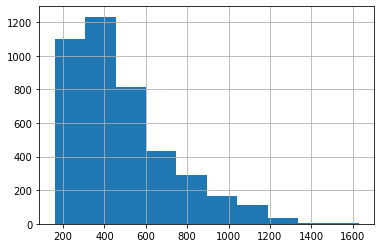

In [30]:
lens = pd.DataFrame()
lens['ln'] = [len(ids) for ids in pdf.input_ids.values]
lens.ln.hist();

In [31]:
import pickle
with open(f'processed-{checkpoint.split("/")[1]}-all.pickle', 'wb') as handle:
    pickle.dump(pdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [32]:
ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Create_MLM_dataset.ipynb  PL-15.ipynb
HF-0.ipynb                PL-16.ipynb
HF-1.ipynb                PL-2.ipynb
HF-10.ipynb               PL-3.ipynb
HF-11.ipynb               PL-4.ipynb
HF-12.ipynb               PL-5.ipynb
HF-2.ipynb                PL-6.ipynb
HF-3.ipynb                PL-7.ipynb
HF-4.ipynb                PL-8.ipynb
HF-5.ipynb                PL-9.ipynb
HF-6.ipynb                deb619.py
HF-7.ipynb                feedback-effective-baseline-3.ipynb
HF-8.ipynb                feedback-effective-create-labels-deb-v3-1024.ipynb
HF-9.ipynb                feedback-effective-create-labels-deb-v3-all.ipynb
PL-1.ipynb                feedback-effective-create-l